# Initialization of CNN Model

Do upload the model folder from github before running this cell

In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential, model_from_json
from tensorflow.keras.utils import to_categorical
from os.path import isfile, join
from keras import backend as K
from os import listdir
from PIL import Image


def extract_imgs(img):
    img = ~img # Invert the bits of image 255 -> 0
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY) # Set bits > 127 to 1 and <= 127 to 0
    ctrs, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0]) # Sort by x

    img_data = []
    rects = []
    for c in cnt :
        x, y, w, h = cv2.boundingRect(c)
        rect = [x, y, w, h]
        rects.append(rect)

    bool_rect = []
    # Check when two rectangles collide
    for r in rects:
        l = []
        for rec in rects:
            flag = 0
            if rec != r:
                if r[0] < (rec[0] + rec[2] + 10) and rec[0] < (r[0] + r[2] + 10) and r[1] < (rec[1] + rec[3] + 10) and rec[1] < (r[1] + r[3] + 10):
                    flag = 1
                l.append(flag)
            else:
                l.append(0)
        bool_rect.append(l)

    dump_rect = []
    # Discard the small collide rectangle
    for i in range(0, len(cnt)):
        for j in range(0, len(cnt)):
            if bool_rect[i][j] == 1:
                area1 = rects[i][2] * rects[i][3]
                area2 = rects[j][2] * rects[j][3]
                if(area1 == min(area1,area2)):
                    dump_rect.append(rects[i])

    # Get the final rectangles
    final_rect = [i for i in rects if i not in dump_rect]
    for r in final_rect:
        x = r[0]
        y = r[1]
        w = r[2]
        h = r[3]

        im_crop = thresh[y:y+h+10, x:x+w+10] # Crop the image as most as possible
        im_resize = cv2.resize(im_crop, (28, 28)) # Resize to (28, 28)
        im_resize = np.reshape(im_resize, (1, 28, 28)) # Flat the matrix
        img_data.append(im_resize)

    return img_data

class ConvolutionalNeuralNetwork:
    def __init__(self):
        if os.path.exists('/content/model.json') and os.path.exists('/content/model_weights.h5'):
            self.load_model()
        else:
            self.create_model()
            self.train_model()
            self.export_model()


    def load_model(self):
        print('Loading Model...')
        model_json = open('/content/model.json', 'r')
        loaded_model_json = model_json.read()
        model_json.close()
        loaded_model = model_from_json(loaded_model_json)

        print('Loading weights...')
        loaded_model.load_weights("/content/model_weights.h5")

        self.model = loaded_model

    def predict(self, operationBytes):
        Image.open(operationBytes).save('_aux_.png')
        img = cv2.imread('_aux_.png',0)
        os.remove('_aux_.png')
        if img is not None:
            img_data = extract_imgs(img)

            operation = ''
            for i in range(len(img_data)):
                img_data[i] = np.array(img_data[i])
                img_data[i] = img_data[i].reshape(-1, 28, 28, 1)

                pred = self.model.predict(img_data[i])
                result=np.argmax(pred,axis=1)
                print(result[0])
                if result[0] == 10:
                    operation += '+'
                elif result[0] == 11:
                    operation += '-'
                elif result[0] == 12:
                    operation += 'x'
                elif result[0] == 13:
                    operation += 'a'
                elif result[0] == 14:
                    operation += 'b'
                else:
                    operation += str(result[0])
            print(f"Operation is {operation}")
            return operation
CNN = ConvolutionalNeuralNetwork()


Loading Model...
Loading weights...


## Simple Polynomial Solving Code

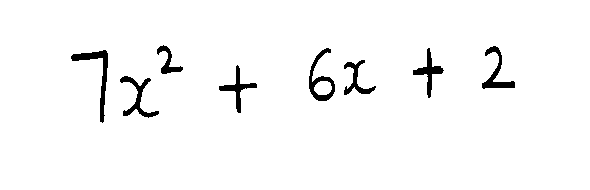

Loading Model...
Loading weights...
1/1 [==============================] - 0s 333ms/step
7
1/1 [==============================] - 0s 22ms/step
2
1/1 [==============================] - 0s 21ms/step
10
1/1 [==============================] - 0s 23ms/step
6
1/1 [==============================] - 0s 27ms/step
10
1/1 [==============================] - 0s 27ms/step
2
Operation is 72+6+2
7*x**2 + 6*x + 2


[-3/7 - sqrt(5)*I/7, -3/7 + sqrt(5)*I/7]

In [ ]:
#Importing the necessary Modules
from google.colab.patches import cv2_imshow
import base64
from sympy.parsing.sympy_parser import parse_expr
from io import BytesIO
import cv2
import re
import numpy as np
from sympy import symbols, Eq, solve
im = cv2.imread("/content/eq7.jpeg",0) # Read the User Image
im = cv2.resize(im,(600,200)) # Resize the User Image as per Model Requirement

# Thresholding the User Image
ret, thresh = cv2.threshold(im, 127, 255, 0)
kernel = np.zeros((3,3),np.uint8)
thresh = cv2.dilate(thresh,kernel,iterations = 1)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
thresh = thresh[10:,10:]
cv2_imshow(thresh)



# Conversion of the threshold image into base64 DataURL
# This is done as our model requires base64 string to detect Equation/Polynomial

retval, buffer_img= cv2.imencode('.png', thresh)
data = base64.b64encode(buffer_img)
data = str(data)
data = str(data)[2:len(data)-1]
operation = BytesIO(base64.urlsafe_b64decode(data))

#Initializing the CNN model
def modifier1(s):
  x = re.split(r'\+|\-',s)
  order = ''
  for i in s:
    if i=='+':
        order+='+'
    elif i == '-':
        order+='-'
  first = x[0]
  second = x[1]
  x[0] = first[:-1]+'*x**2'
  x[1] = second[:-1]+'*x' if len(second)>1 else second+'*x'
  eqn = x[0]+order[0]+x[1]+order[1]+x[2]
  return eqn

CNN = ConvolutionalNeuralNetwork()
operation = CNN.predict(operation) # Feeding the base64 string to the the CNN Model
eqn = modifier1(operation)
x = symbols('x')
eqn = parse_expr(eqn)

print(eqn)
solve((eqn), (x))

## Linear Equation in Two Variable

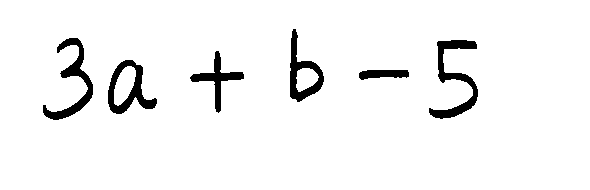

Loading Model...
Loading weights...
1/1 [==============================] - 0s 152ms/step
3
1/1 [==============================] - 0s 39ms/step
13
1/1 [==============================] - 0s 48ms/step
10
1/1 [==============================] - 0s 26ms/step
14
1/1 [==============================] - 0s 25ms/step
11
1/1 [==============================] - 0s 26ms/step
5
Operation is 3a+b-5


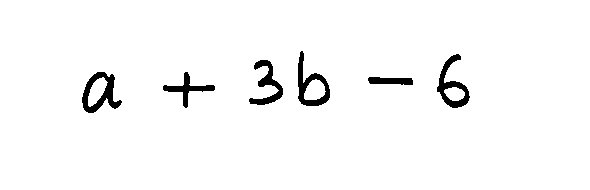

Loading Model...
Loading weights...
1/1 [==============================] - 0s 84ms/step
13
1/1 [==============================] - 0s 28ms/step
10
1/1 [==============================] - 0s 22ms/step
3
1/1 [==============================] - 0s 26ms/step
14
1/1 [==============================] - 0s 23ms/step
11
1/1 [==============================] - 0s 22ms/step
6
Operation is a+3b-6
Eq(3*a + b - 5, 0)
Eq(a + 3*b - 6, 0)
Values of 2 unknown variable are as follows:
{a: 9/8, b: 13/8}


<ipython-input-5-647f0b3e5363>:71: SymPyDeprecationWarning: 

Eq(expr) with a single argument with the right-hand side
defaulting to 0 is deprecated. Use Eq(expr, 0) instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-eq-expr
for details.

This has been deprecated since SymPy version 1.5. It
will be removed in a future version of SymPy.

  eq1 = Eq((eq1))


In [ ]:
#Importing the necessary Modules
import re
import numpy as np
from sympy.parsing.sympy_parser import parse_expr
from sympy import symbols, Eq, solve
import cv2
from google.colab.patches import cv2_imshow
import base64
from io import BytesIO

ls = []
filenames = ["/content/eq21.jpeg","/content/eq22.jpeg"] #filenames for the linear equations
#Run for loops for two times to get the two eqyations from the images specifed as filenames
for i in range(0,2):
  im = cv2.imread(filenames[i],0)# Read the User Image
  im = cv2.resize(im,(600,200))# Resize the User Image as per Model Requirement

  # Thresholding the User Image

  ret, thresh = cv2.threshold(im, 127, 255, 0)
  kernel = np.zeros((3,3),np.uint8)
  thresh = cv2.dilate(thresh,kernel,iterations = 1)
  thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
  thresh = thresh[10:,10:]
  cv2_imshow(thresh)


  # Conversion of the threshold image into base64 DataURL
  # This is done as our model requires base64 string to detect Equation/Polynomial

  retval, buffer_img= cv2.imencode('.png', thresh)
  data = base64.b64encode(buffer_img)
  data = str(data)
  data = str(data)[2:len(data)-1]

  #Initializing the CNN model
  operation = BytesIO(base64.urlsafe_b64decode(data))
  CNN = ConvolutionalNeuralNetwork()
  operation = CNN.predict(operation)
  ls.append(operation)


def modifier(s):
    x = re.split(r'\+|\-',s)

    order = ''
    eqn = ''

    for i in s:
        if i=='+':
            order+='+'
        elif i == '-':
            order+='-'

    for i in range(len(x)-1):
        elem = x[i]
        if len(elem)>1:
          x[i] = elem[:-1]+'*'+elem[-1]

    eqn = x[0]+order[0]+x[1]+order[1]+x[2]
    return eqn

#putting both equation in variables
eq1 = modifier(ls[0])
eq2 = modifier(ls[1])

#Initializing the solving process using the sympy module

x, y = symbols('a b')
eq1 = parse_expr(eq1)
eq1 = Eq((eq1))
eq2 = parse_expr(eq2)
eq2 = Eq((eq2))

print(eq1)

print(eq2)


# solving the equation
print("Values of 2 unknown variable are as follows:")

print(solve((eq1, eq2), (x, y)))
